In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_tracks.csv').drop(['Unnamed: 0', 'name'],axis = 1)

**ШАГ 1**: Стандартизируем данные

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('popularity', axis = 1),
                                                   df.popularity,
                                                   test_size = 0.3,
                                                   random_state = np.random.seed(1))

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**ШАГ 2**: Обучим линейную регрессию

Измерять качество модели мы будем на MAE, поскольку из визуализации мы сделали вывод о наличии выбросов, и именно эта метрика менее чувствительна к ним. \
Для начала построим линейную регрессии с Lasso-регуляризацией и сразу подберем оптимальный вес регуляризатора с помощью кросс-валидации на 5 фолдах:

In [5]:
alpha_arr = np.arange(0,10,0.1)
model_lasso = linear_model.LassoCV(cv=5,alphas=alpha_arr).fit(X_train, y_train)
index = model_lasso.mse_path_.mean(axis = 1).argmin()
model_lasso.alphas_[index]

0.0

Таким образом, лучше не использовать регуляризатор. Обучим модель без регуляризатора на MAE и измерим значение ошибки:

In [6]:
model_mae = linear_model.SGDRegressor(loss='epsilon_insensitive', epsilon=0)
model_mae.fit(X_train, y_train)
y_mae_test = model_mae.predict(X_test)
MAE = mean_absolute_error(y_test, y_mae_test)
print(f'MAE = {MAE}')

MAE = 12.222514070602909


Для оценки качества модели мы также решили использовать MAPE. Поскольку в формуле MAPE настоящее значение целевой переменной стоит в знаменателе, нам нужно избавиться от нулей среди ее значений (иначе ошибка будет стремиться к бесконечности). Заменим эти значения на 1 (для подсчета ошибки):

In [7]:
y_test1 = y_test
y_test1[y_test1 == 0] = 1

In [8]:
print(f'MAPE = {mean_absolute_percentage_error(y_test1, y_mae_test)}')

MAPE = 0.5077648467588631


Проанализируем коэффициенты параметров:

In [9]:
model_mae.coef_

array([-0.5376811 ,  3.23112454, -3.21862666, -1.49057682,  0.39648505,
       -1.1085376 , -0.43234347,  2.99707752])

Можно сделать вывод, что наиболее важными признаками в полученной регрессии являются содержание матов в песне(что подтрерждалось и проверенной нами гипотезой), номер песни в альбоме (гипотеза об этой зависимости также была проверена перестановочным тестом), и совместный показатель громность-энергичность. 

**ШАГ 3**: Обучим решающее дерево

Подберем оптимальную глубину дерева:

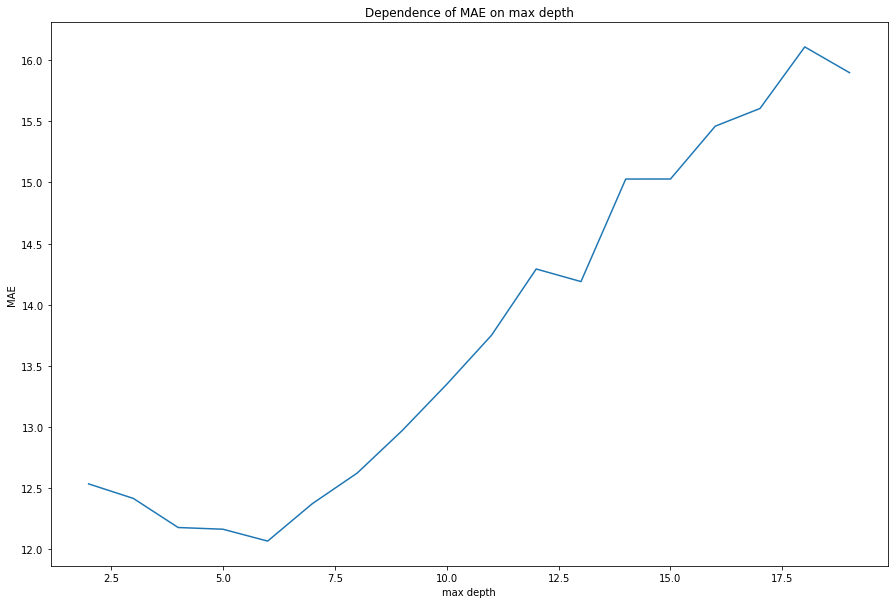

In [10]:
max_depth_array = range(2, 20)
mae_list = []

for max_depth in max_depth_array:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=1)
    dt.fit(X_train, y_train)
    mae_list.append(mean_absolute_error(y_test, dt.predict(X_test)))

plt.figure(figsize = (15,10))
plt.plot(max_depth_array, mae_list)
plt.title("Dependence of MAE on max depth")
plt.xlabel("max depth")
plt.ylabel("MAE");

Посмотрев на график, можно заметить, что у нас есть четкий минимум значения MAE. Выведем оптимальную глубину дерева:

In [11]:
max_depth_array[np.argmin(np.array(mae_list))]

6

Подберем оптиамальное число минимального количества объектов на одном листе:

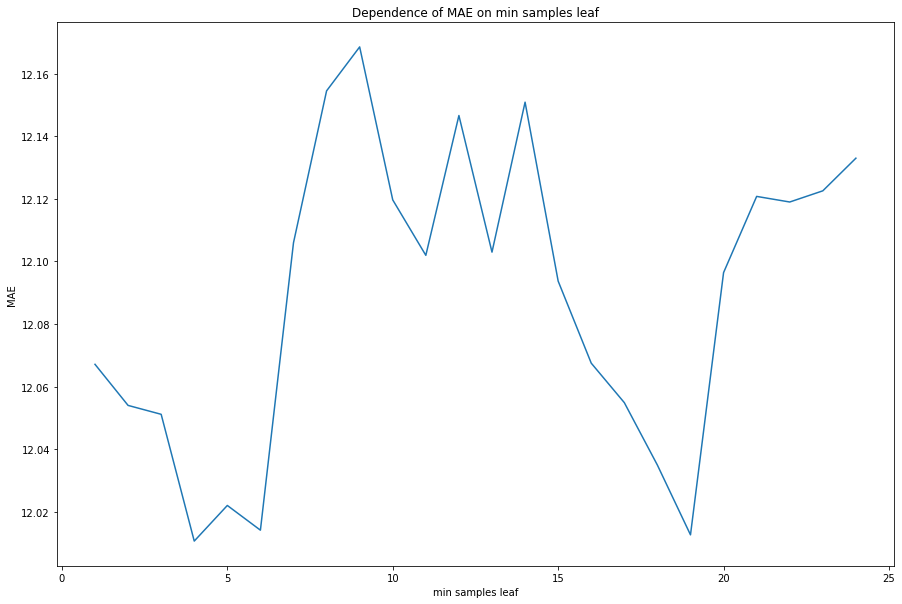

In [12]:
min_samples_leaf_array = range(1, 25)
mae_list = []

for min_samples_leaf in min_samples_leaf_array:
    dt = DecisionTreeRegressor(
        max_depth=6, min_samples_leaf=min_samples_leaf, random_state=1
    )
    dt.fit(X_train, y_train)
    mae_list.append(mean_absolute_error(y_test, dt.predict(X_test)))

plt.figure(figsize = (15,10))
plt.plot(min_samples_leaf_array, mae_list)
plt.title("Dependence of MAE on min samples leaf")
plt.xlabel("min samples leaf")
plt.ylabel("MAE");

Выведем оптимальное число min_samples_leaf:

In [13]:
min_samples_leaf_array[np.argmin(np.array(mae_list))]

4

Проанализируем важность признаков в полученной модели:

In [14]:
dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf = 4, random_state=1)
dt.fit(X_train, y_train)
dt.feature_importances_

array([0.16669678, 0.08403647, 0.15128464, 0.22853631, 0.01284873,
       0.02831887, 0.02082103, 0.30745716])

В случае решающего дерева наиболее важными признаками оказались общий признак громкость-энергичность, доля разговорной речи в песне, ее длительность и номер. Таким образом, пересечения с регрессией видны в громкости-энергичности и номера песни.

In [15]:
pred = dt.predict(X_test)
print(f'MAE = {mean_absolute_error(y_test, pred)}')
print(f'MAPE = {mean_absolute_percentage_error(y_test1, pred)}')

MAE = 12.01066099190419
MAPE = 0.5102432783965882


**Вывод**: как можно заметить по получившимся значениям параметров оценки, обе модели выдают примерно одинаковый результат, хотя, если судить по метрике MAE, решающее дерево предсказывает результат лучше. Несмотря на это, в обоих случаях результат оказался не столь хорошим. Это могло произойти из-за того, что большинство значений целевой переменной в выборке пренадлежит от 50 до 70. Из-за этого модели так же начинают предсказывать значения примерно в этом диапазоне, хотя в действительности не все песни обладают такой популярностью. Также возможной причиной такого качества моделей может являтьcя то, что параметр популярности изначально рассчитывается по другим показателям, недоступным нам.